# An Improved Reliability-Based Approach to Sepcifying Fire Resistance Periods For Buildings in England

Analysis documentation for the research topic submitted for ASFE 2021.

_2021 April, Ian F._

In the design of fire safety provisions for straightforward/common buildings in England the appropriate structural fire resistance is selected from guidance based upon building height and occupancy characteristics. This has been expanded upon in contemporary guidance to include consideration of ventilation conditions informed by work carried out in 2004 by Kirby, et al. in their paper “A new approach to specifying fire resistance periods” and has been implemented in British Standard, BS 9999:2017. In the work of Kirby, et al., a probabilistic time equivalence analysis was carried out using Monte Carlo simulations (MCS). Stochastic parameters were used to produce a range of credible design fires. These were primarily fuel load density, compartment geometry and ventilation opening size. The design fires were generated using the parametric fire model in EN 1991-1-2 and the contribution of sprinklers was considered through a reduced fire load. To link to existing fire resistance recommendations which did not consider ventilation, the safety/reliability target was calibrated to align with statutory guidance, Approved Document B (ADB), using a medium-rise office as an anchor point.

This study revisits the work of Kirby et al., resolving key limitations and incorporating advancements in the field to present a new approach to assessing the recommended fire resistance for structures and proposes a revised fire resistance design table for England. To seek alignment with general structural design principles/requirements, as defined in Approved Document A (ADA), safety targets are expressed in function of consequence classes in lieu of building height and use. Other key advancements include improved stochastic parameters, the use of travelling fires where post-flashover parametric fires are unrealistic (i.e., a more explicit consideration of large enclosure fire dynamics), and consideration of sprinkler contribution in the event tree in terms of their ability to mitigate structurally significant fire occurrences.

The improved approach presented provides a more up to date method for defining appropriate fire resistance for straightforward/common buildings in England.

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import pprint as pp
import matplotlib.pyplot as plt
from os import path
from scipy import stats
from sys import platform
from typing import Callable, Union
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
from IPython.display import display, HTML

from sfeprapy.mcs2 import MCS2, EXAMPLE_INPUT_DF
from sfeprapy.mcs.mcs_gen_2 import InputParser

from asfe2021 import (
    get_fr_func, get_teq_fractile, get_teq_fractile, get_teq_fractile_dict, 
    format_ax, plot_contour, plot_contour_text_p_i, ax_annotate,
    func_cdf_teq_from_area_height, func_teq_from_area_height
)

plt.style.use('seaborn-white')

# Helper function: print DataFrame in HTML format
def print_df(df: pd.DataFrame):
    display(HTML(df.to_html()))

fp_fig = ''

## Benchmark against Kirby et al

### Prepare MCS inputs

The analysis is comprised of three cases: Office, Resiential and Retail. All input parameters are inline with Kirby et al.

MCS inputs are prepared in accordance with Kirby et al with several adjustments below:

In [2]:
df_inputs_1 = EXAMPLE_INPUT_DF.copy()
# df_inputs_2 = df_inputs.copy()
df_inputs_1.loc['fire_mode'] = 0  # use only parametric
df_inputs_1.loc['fire_combustion_efficiency:lbound'] = 0.99999
df_inputs_1.loc['n_simulations'] = 10_000  # 10k for initial inspection, 10x more than kirby et al

items_to_drop = [
    'phi_teq:dist', 'phi_teq:mean', 'phi_teq:sd', 'phi_teq:ubound', 'phi_teq:lbound',
    'window_open_fraction:dist', 'window_open_fraction:ubound', 'window_open_fraction:lbound', 'window_open_fraction:mean', 'window_open_fraction:sd'
]
df_inputs_1.drop(items_to_drop, inplace=True)
items_to_add = {'phi_teq': 1, 'window_open_fraction': 1}
df_ = pd.DataFrame.from_dict(dict(Residential=items_to_add, Office=items_to_add, Retail=items_to_add))
df_.index.name = 'case_name'
df_inputs_1 = df_inputs_1.append(df_)

print_df(df_inputs_1)

,Residential,Office,Retail
case_name,,,
n_simulations,10000,10000,10000
fire_time_step,10,10,10
fire_time_duration,18000,18000,18000
fire_hrr_density:dist,uniform_,uniform_,uniform_
fire_hrr_density:lbound,0.32,0.15,0.27
fire_hrr_density:ubound,0.57,0.65,1.0
fire_load_density:dist,gumbel_r_,gumbel_r_,gumbel_r_
fire_load_density:lbound,10,10,10.0
fire_load_density:ubound,2000,1200,2000.0


### Run MCS

In [3]:
# Run MCS
cases_to_run=['Residential', 'Office', 'Retail']

mcs_1 = MCS2(print_stats=False)
mcs_1.inputs = df_inputs_1
mcs_1.n_threads = 6
mcs_1.run_mcs(cases_to_run=cases_to_run)

CASE                    : Residential
NO. OF THREADS          : 6
NO. OF SIMULATIONS      : 10000


100%|███████████████| 10000/10000 [00:05<00:00, 1959.59it/s]


CASE                    : Office
NO. OF THREADS          : 6
NO. OF SIMULATIONS      : 10000


100%|███████████████| 10000/10000 [00:03<00:00, 3297.07it/s]


CASE                    : Retail
NO. OF THREADS          : 6
NO. OF SIMULATIONS      : 10000


100%|███████████████| 10000/10000 [00:03<00:00, 3261.86it/s]


### Time equivalence results

Inspect simulation results to ensure the simulations are complete successfully.

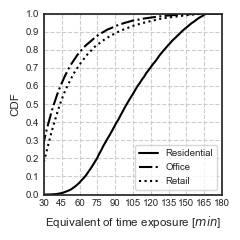

In [4]:
# Inspect simulation results
mcs_out_1 = mcs_1.mcs_out
dict_teq_1 = {case: mcs_out_1.loc[mcs_out_1['case_name'] == case]["solver_time_equivalence_solved"] / 60.0 for case in cases_to_run}
dict_teq_1 = {k: v[~np.isnan(v)] for k, v in dict_teq_1.items()}  # remove np.nan values, non convergency iterations
dict_teq_fractile_1 = get_teq_fractile_dict(dict_teq_1, is_print=False, fr=np.linspace(0, 180, 100))

fig, ax = plt.subplots(figsize=(2.5,2.5), dpi=100)
lss=['-', '-.', 'dotted']
for i, case in enumerate(cases_to_run):
    ax.plot(dict_teq_fractile_1['Time'], dict_teq_fractile_1[case], label=case, ls=lss[i], c='k')
format_ax(ax=ax, xlabel='Equivalent of time exposure [$min$]', ylabel='CDF', xlim=(30, 180), ylim=(0, 1), xticks=np.arange(30, 181, 15,), yticks=np.arange(0, 1.1, 0.1))

plt.tight_layout()
fig.savefig(path.join('fig', 'teq_1.png'), dpi=300, bbox_inches='tight', pad_inches=0)

It is obvious Residential produced much worse time equivalence results comparing to the other two, primarily due to higher fuel load density.

### Comparing agsint Kirby et al

| FR  | Office | Retail  | Residential |
|-----|--------|---------|-------------|
| 30  | 0.464  | 0.40416 | 0.16901     |
| 45  | 0.6474 | -       | 0.19285     |
| 60  | 0.8    | 0.73384 | 0.36078     |
| 75  | 0.8963 | -       | 0.62947     |
| 90  | 0.928  | 0.91238 | 0.84399     |
| 105 | 0.9727 | -       | 0.95341     |
| 120 | 0.982  | 0.96824 | 0.99133     |

In [5]:
teq_cdf_kirby = [  # order matters!
    [[60, 75, 90, 105, 120], [0.361, 0.629, 0.844, 0.953, 0.991]],  # Residential
    [[30, 60, 90, 120], [0.464, 0.800, 0.928, 0.982]],  # Office
    [[30, 60, 90, 120], [0.404, 0.734, 0.912, 0.968]],  # Retail
]

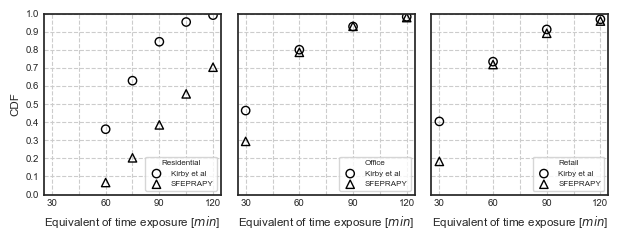

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(2.1*3, 2.5), sharex=True, sharey=True, dpi=100)

for i, case in enumerate(cases_to_run):
    ax = axes[i]
    ax.scatter(teq_cdf_kirby[i][0], teq_cdf_kirby[i][1], label='Kirby et al', marker='o', facecolors='none', edgecolors='k')
    ax.scatter(teq_cdf_kirby[i][0], get_teq_fractile(teq=dict_teq_1[case], fr=teq_cdf_kirby[i][0]), label='SFEPRAPY', marker='^', facecolors='none', edgecolors='k')
    format_ax(ax=ax, xlabel='Equivalent of time exposure [$min$]', xticks=np.arange(30, 121, 30), xticks_minor=np.arange(30, 121, 15), ylim=(0, 1), yticks=np.arange(0, 1.1, 0.1), legend_title=case, legend_loc=4, legend_fontsize='xx-small', legend_title_fontsize='xx-small')
axes[0].set_ylabel('CDF', fontsize='small')

plt.tight_layout()
fig.savefig(path.join('fig', 'benchmark_1.png'), dpi=300, bbox_inches='tight', pad_inches=0.02)

## Allowable failure probability

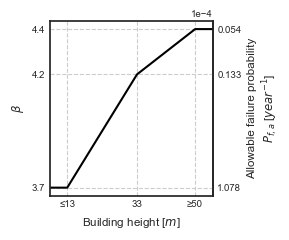

In [7]:
# Define correlation between building height and beta values
storey = [4, 10, 15]
height = [i*3.333 for i in storey]
beta =   [3.7, 4.2, 4.4]
func_beta = interp1d(height, beta, bounds_error=False, fill_value=(beta[0], beta[-1]))

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=100)
ax.plot(np.linspace(0, 100, 1000), func_beta(np.linspace(0, 100, 1000)), c='k')
format_ax(
    ax=ax, xlabel='Building height [$m$]', ylabel=r'$\beta$', 
    xticks=height, xticklabels=[f'≤{height[0]:.0f}']+[f'{i:.0f}' for i in height[1:-1]]+[f'≥{height[-1]:.0f}'], xlim=(min(height)-5, max(height)+5), 
    yticks=beta,
    legend_visible=False
)

n = stats.norm(loc=0, scale=1)
ax_yaxis2 = ax.secondary_yaxis('right', functions=(lambda x: n.cdf(-x), lambda x: -n.ppf(x)))
ax_yaxis2.set_yticks([n.cdf(-i) for i in beta])
ax_yaxis2.ticklabel_format(style='sci', scilimits=(0, 0))
ax_yaxis2.set_ylabel('Allowable failure probability\n$P_{f,a}$ [${year}^{-1}$]', fontsize='small')
ax_yaxis2.tick_params(labelsize='x-small')
ax_yaxis2.yaxis.offsetText.set_fontsize('x-small')

plt.tight_layout()
plt.show()
fig.savefig(path.join('fig', 'beta_vs_H.png'), dpi=300, bbox_inches='tight', pad_inches=0)

## Structural failure probability
### Prepare MCS inputs

In [8]:
# Update inputs to include travelling fire model and other parameters
df_inputs_2 = EXAMPLE_INPUT_DF.copy()
df_inputs_2.loc['n_simulations'] = 100_000  # set to simulation iteration to 10k to make fine plots later
df_inputs_2.loc['solver_thickness_ubound'] = 0.045

print_df(df_inputs_2)

,Residential,Office,Retail
case_name,,,
n_simulations,100000,100000,100000
fire_time_step,10,10,10
fire_time_duration,18000,18000,18000
fire_hrr_density:dist,uniform_,uniform_,uniform_
fire_hrr_density:lbound,0.32,0.15,0.27
fire_hrr_density:ubound,0.57,0.65,1.0
fire_load_density:dist,gumbel_r_,gumbel_r_,gumbel_r_
fire_load_density:lbound,10,10,10.0
fire_load_density:ubound,2000,1200,2000.0


### Run MCS

In [9]:
# Run MCS
cases_to_run=['Residential', 'Office', 'Retail']
mcs_2 = MCS2(print_stats=False)
mcs_2.inputs = df_inputs_2
mcs_2.n_threads = 4
mcs_2.run_mcs(cases_to_run=cases_to_run)

CASE                    : Residential
NO. OF THREADS          : 4
NO. OF SIMULATIONS      : 100000


100%|█████████████| 100000/100000 [00:46<00:00, 2173.16it/s]


CASE                    : Office
NO. OF THREADS          : 4
NO. OF SIMULATIONS      : 100000


100%|█████████████| 100000/100000 [00:44<00:00, 2227.14it/s]


CASE                    : Retail
NO. OF THREADS          : 4
NO. OF SIMULATIONS      : 100000


100%|█████████████| 100000/100000 [00:44<00:00, 2246.55it/s]


### Time equivalence results

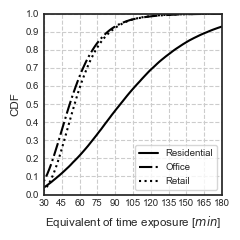

In [10]:
# Inspect simulation results
mcs_out_2 = mcs_2.mcs_out
dict_teq_2 = {case: mcs_out_2.loc[mcs_out_2['case_name'] == case]["solver_time_equivalence_solved"] / 60.0 for case in cases_to_run}
dict_teq_2 = {k: v[~np.isnan(v)] for k, v in dict_teq_2.items()}  # remove np.nan values, non convergency iterations
dict_teq_fractile_2 = get_teq_fractile_dict(dict_teq_2, is_print=False, fr=np.linspace(0, 180, 100))

fig, ax = plt.subplots(figsize=(2.5,2.5), dpi=100)
lss=['-', '-.', 'dotted']
for i, case in enumerate(cases_to_run):
    ax.plot(dict_teq_fractile_2['Time'], dict_teq_fractile_2[case], label=case, ls=lss[i], c='k')
format_ax(ax=ax, xlabel='Equivalent of time exposure [$min$]', ylabel='CDF', xlim=(30, 180), ylim=(0, 1), xticks=np.arange(30, 181, 15,), yticks=np.arange(0, 1.1, 0.1))

plt.tight_layout()
fig.savefig(path.join('fig', 'teq_2.png'), dpi=300, bbox_inches='tight', pad_inches=0)

### Comparing against Kirby et al

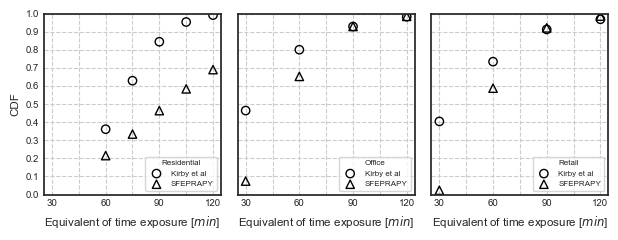

In [11]:
# Compare against Kirby
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(2.1*3, 2.5), sharex=True, sharey=True, dpi=100)

for i, case in enumerate(cases_to_run):
    ax = axes[i]
    ax.scatter(teq_cdf_kirby[i][0], teq_cdf_kirby[i][1], label='Kirby et al', marker='o', facecolors='none', edgecolors='k')
    ax.scatter(teq_cdf_kirby[i][0], get_teq_fractile(teq=dict_teq_2[case], fr=teq_cdf_kirby[i][0]), label='SFEPRAPY', marker='^', facecolors='none', edgecolors='k')
    format_ax(ax=ax, xlabel='Equivalent of time exposure [$min$]', xticks=np.arange(30, 121, 30), xticks_minor=np.arange(30, 121, 15), ylim=(0, 1), yticks=np.arange(0, 1.1, 0.1), legend_title=case, legend_loc=4, legend_fontsize='xx-small', legend_title_fontsize='xx-small')
axes[0].set_ylabel('CDF', fontsize='small')

plt.tight_layout()
fig.savefig(path.join('fig', 'benchmark_2.png'), dpi=300, bbox_inches='tight', pad_inches=0.02)

### Failure probabilies

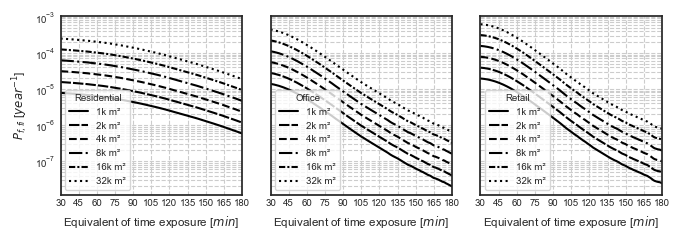

In [12]:
dict_p_i = {
    "Residential": dict(p_1=6.5e-7, p_2=0.2, p_3=0.0625, p_4=1),
    "Office": dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=1),
    "Retail": dict(p_1=4.0e-7, p_2=0.2, p_3=0.25, p_4=1),
}

def P_f_fi_func(p_1: float, p_2: float, p_3: float, p_4: float, A: np.ndarray, teq: np.ndarray) -> pd.DataFrame:
    P_f_fi_ = dict(FR = np.arange(30, 181, 1))
    p_5 = 1 - get_teq_fractile(teq=teq, fr=P_f_fi_['FR'])
    for i in A:
        P_f_fi_[f'{i/1e3:.0f}k m²'] = p_1 * i * p_2 * p_3 * p_4 * p_5
    return pd.DataFrame.from_dict(P_f_fi_).set_index('FR')

As = [1000, 2000, 4000, 8000, 16000, 32000]
dict_dfs = dict()
for occupancy, p_i  in dict_p_i.items():
    dict_dfs[occupancy] = P_f_fi_func(A=As, teq=dict_teq_2[occupancy], **p_i)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(2.3*3, 2.5), sharex=True, sharey=True, dpi=100)
lss = ['-', (0, (5, 1)), '--', '-.', (0, (3, 1, 1, 1)), ':', (0, (5, 10))]
for i, key in enumerate(dict_dfs.keys()):
    ax = axes[i]
    df = dict_dfs[key]
    x = df.index.values
    ys = df.to_dict(orient='list')
    for j, key_ in enumerate(ys):
        y = ys[key_]
        ax.plot(x, y, label=key_, ls=lss[j], c='k')
    format_ax(
        ax=ax, xlabel='Equivalent of time exposure [$min$]',
        xlim=(30, 180), xticks=np.arange(30, 181, 15),
        yscale='log', 
        legend_title=key, legend_ncol=1, legend_loc=3
    )

ax = axes[0]
ax.set_ylabel(r'$P_{f,fi}$ [${year}^{-1}$]', fontsize='small')

plt.tight_layout()
fig.savefig(path.join('fig', 'P_f_fi_vs_A.png'), dpi=300, bbox_inches='tight', pad_inches=0.01)

## Recommended fire resistance periods
### Buildings without sprinklers

In [13]:
# define correlation between height and total floor area
# resi, 10 flats per storey, each flat is 80 sq.m
# office/retail, 1200 sq.m per storey
dict_H_per_storey = dict(Residential=2.4, Office=3.4, Retail=4)
dict_A_per_storey = dict(Residential=800, Office=1200, Retail=1200)
def func_A_vs_H(occupancy: str, height: Union[float, int, np.ndarray]):
    return height / dict_H_per_storey[occupancy] * dict_A_per_storey[occupancy]

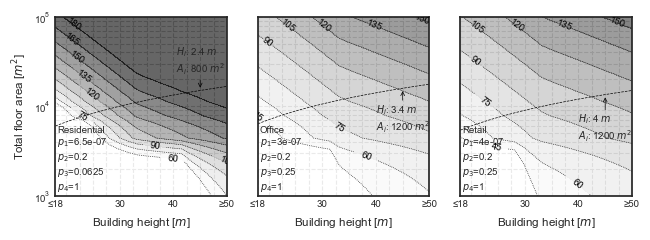

In [14]:
# define p parameters
dict_p_i = {
    "Residential": dict(p_1=6.5e-7, p_2=0.2, p_3=0.0625, p_4=1),
    "Office": dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=1),
    "Retail": dict(p_1=4.0e-7, p_2=0.2, p_3=0.25, p_4=1),
}

# calculate time equivalence
height, area = np.meshgrid(np.linspace(18, 50, 20), np.linspace(1000, 100000, 30))
teqs_no_sprinklers = dict()
for case, ps in dict_p_i.items():
    teq_cdf = func_cdf_teq_from_area_height(area=area, height=height, func_beta_from_height=func_beta, **ps)
    teq = func_teq_from_area_height(area=area, height=height, teq_cdf=teq_cdf, teq=dict_teq_2[case])
    teq[teq_cdf<0] = 0  # for instances where P_a_fi / (p_1 * A * p_2 * p_3 * p_4) is greater than 1, set it to 1, i.e., CDF teq = 0
    teqs_no_sprinklers[case] = teq

# visualisation, logscale
teqs = teqs_no_sprinklers
fig, axes = plt.subplots(figsize=(2.2*3, 2.5), nrows=1, ncols=3, dpi=100, sharex=True, sharey=True)
for i, key in enumerate(teqs):
    Hs = np.linspace(np.amin(height), np.amax(height), 50)
    As = func_A_vs_H(occupancy=key, height=Hs)
    levels = np.arange(60, 181, 15) if key == 'Residential' else np.arange(45, 181, 15)
    ax = axes[i]
    plot_contour_text_p_i(ax=ax, title=key, p_i=dict_p_i[key], ha='left', va='bottom', x=0.01, y=0.01, bbox_pad=0.4, bbox_fc=(0,0,0,0))
    cf = plot_contour(
        ax=ax, xx=height, yy=area, zz=teqs[key], xlabel = 'Building height [$m$]', levels=levels,
        xticks=[18, 30, 40, 50], 
        xticks_minor=np.arange(20, 50, 2.5),
        xticklabels=['≤18', 30, 40, '≥50'],
    )
    # add line text
    ax.plot(Hs, As, c='k', lw=.5, ls='--')
    xy=(45, func_A_vs_H(key, 45))
    if key=='Residential':
        ax_annotate(ax, text=f'$H_i$: {dict_H_per_storey[key]} $m$\n$A_i$: {dict_A_per_storey[key]} $m^2$', xy=xy, xytext=(xy[0], xy[1]+0.6e4), bbox_fc=(0,0,0,0), va='bottom')
    else:
        ax_annotate(ax, text=f'$H_i$: {dict_H_per_storey[key]} $m$\n$A_i$: {dict_A_per_storey[key]} $m^2$', xy=xy, xytext=(xy[0], xy[1]-0.5e4), bbox_fc=(0,0,0,0), va='top')

axes[0].set_ylabel('Total floor area [$m^2$]', fontsize='small')
axes[0].set_yscale('log')
plt.tight_layout()
plt.show()

fig.savefig(path.join('fig', 'contour_1_logscale.png'), bbox_inches='tight', dpi=300, pad_inches=0)

# cbar = fig.colorbar(cf, ax=axes[:], shrink=0.8, location='right')
# cbar.ax.tick_params(labelsize='x-small')
# fig.savefig(path.join('fig', 'contour_1_colorbar_logscale.png'), bbox_inches='tight', dpi=300, pad_inches=0)

### Buildings with sprinklers

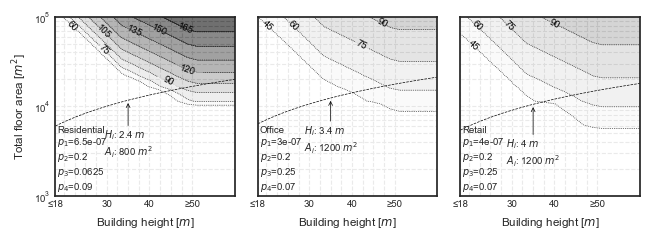

In [15]:
# define p parameters
dict_p_i = {
    "Residential": dict(p_1=6.5e-7, p_2=0.2, p_3=0.0625, p_4=0.09),
    "Office": dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=0.07),
    "Retail": dict(p_1=4.0e-7, p_2=0.2, p_3=0.25, p_4=0.07),
}

# calculate time equivalence
height, area = np.meshgrid(np.linspace(18, 60, 20), np.linspace(1000, 100000, 20))
teqs_with_sprinklers = dict()
for case, ps in dict_p_i.items():
    teq_cdf = func_cdf_teq_from_area_height(area=area, height=height, func_beta_from_height=func_beta, **ps)
    teq = func_teq_from_area_height(area=area, height=height, teq_cdf=teq_cdf, teq=dict_teq_2[case])
    teq[teq_cdf<0] = 0  # for instances where P_a_fi / (p_1 * A * p_2 * p_3 * p_4) is greater than 1, set it to 1, i.e., CDF teq = 0
    teqs_with_sprinklers[case] = teq

# visualisation, logscale
teqs = teqs_with_sprinklers
fig, axes = plt.subplots(figsize=(2.2*3, 2.5), nrows=1, ncols=3, dpi=100, sharex=True, sharey=True)
for i, key in enumerate(teqs):
    Hs = np.linspace(np.amin(height), np.amax(height), 50)
    As = func_A_vs_H(occupancy=key, height=Hs)
    levels = np.arange(60, 181, 15) if key == 'Residential' else np.arange(45, 181, 15)
    ax = axes[i]
    plot_contour_text_p_i(ax=ax, title=key, p_i=dict_p_i[key], ha='left', va='bottom', x=0.01, y=0.01, bbox_pad=0.4, bbox_fc=(0,0,0,0))
    cf = plot_contour(
        ax=ax, xx=height, yy=area, zz=teqs[key], xlabel = 'Building height [$m$]', levels=levels,
        xticks=[18, 30, 40, 50], 
        xticks_minor=np.arange(20, 50, 2.5),
        xticklabels=['≤18', 30, 40, '≥50'],
    )
    # add line text
    ax.plot(Hs, As, c='k', lw=.5, ls='--')
    xy=(35, func_A_vs_H(key, 35))
    ax_annotate(ax, text=f'$H_i$: {dict_H_per_storey[key]} $m$\n$A_i$: {dict_A_per_storey[key]} $m^2$', xy=xy, xytext=(xy[0], xy[1]-0.6e4), va='top', bbox_fc=(0,0,0,0))

axes[0].set_ylabel('Total floor area [$m^2$]', fontsize='small')
axes[0].set_yscale('log')
plt.tight_layout()
plt.show()

fig.savefig(path.join('fig', 'contour_2_logscale.png'), bbox_inches='tight', dpi=300, pad_inches=0)

# cbar = fig.colorbar(cf, ax=axes[:], shrink=0.8, location='right')
# cbar.ax.tick_params(labelsize='x-small')
# fig.savefig(path.join('fig', 'contour_2_colorbar_logscale.png'), bbox_inches='tight', dpi=300, pad_inches=0)

### Comparing against BS 9999:2017

In [16]:
# A helper function to determine the required fire resistance periods
def get_fr(height, occupancy, sprinkler:bool, dict_teq, func_beta):
    
    # work out p_i
    if occupancy == 'Residential': p_i=dict(p_1=6.5e-7, p_2=0.2, p_3=0.0625, p_4=.09)
    if occupancy == 'Office': p_i=dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=.07)
    if occupancy == 'Retail': p_i=dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=.07)
    if sprinkler is False:
        p_i['p_4'] = 1.0
    
    # work out total floor area
    A = func_A_vs_H(occupancy=occupancy, height=height)
    
    # work out teq
    teq = dict_teq[occupancy]
    
    teq_cdf = func_cdf_teq_from_area_height(area=A, height=height, func_beta_from_height=func_beta, **p_i)
    teq = func_teq_from_area_height(area=np.array([area]), height=np.array([height]), teq_cdf=teq_cdf, teq=teq)
    return teq

In [17]:
for method in ['SFEPRAPY']:
    for occupancy in ['Residential', 'Office', 'Retail']:
        for sprinkler in [False, True]:
            frs = get_fr(np.array([18, 30, 60, 100]), occupancy, sprinkler, dict_teq_2, func_beta)
            frs[frs==0] = 60 if occupancy == 'Residential' else 45
            frs = np.ceil(frs/15)*15
            frs = [f'{k:3.0f}' for k in frs]
            print(f'{str(method):10} {occupancy:<15} {str(sprinkler):<10} {" ".join(frs)}')

SFEPRAPY   Residential     False       60 135 210 225
SFEPRAPY   Residential     True        60  60 120 150
SFEPRAPY   Office          False       45  90 120 135
SFEPRAPY   Office          True        45  45  75  90
SFEPRAPY   Retail          False       45  90 120 135
SFEPRAPY   Retail          True        45  45  75  90
